[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mjwen/chee6397/blob/main/lab/lab4-descriptors.ipynb)

# Lab 4: Descriptors for Molecules and Materials 

This notebook is intended to introduce the use of molecular and materials descriptors to obtain features for machine learning.

We will cover the use of `RDKit` to generate molecular descriptors, and `Matminer` and `Dscrib` to generate materials descriptors.


## Installation 

- To install `RDKit` follow the instructions [here](https://www.rdkit.org/docs/Install.html)
- To install `Matminer` follow the instructions [here](https://hackingmaterials.lbl.gov/matminer/installation.html)
- To install `Dscribe` follow the instructions [here](https://singroup.github.io/dscribe/latest/install.html)

**Optional**

For visualization of the crystals in Jupyter Notebook, install [crystal-toolkit](https://docs.crystaltoolkit.org/introduction.html)

## RDKit 

### Create molecules

In [1]:
# Smiles string of a molecule

benzene_smi = "c1ccccc1"

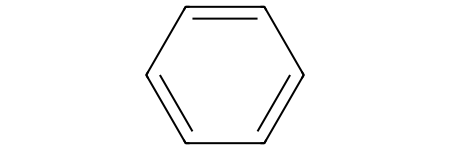

In [2]:
# Rdkit molecule

from rdkit import Chem

benzene = Chem.MolFromSmiles(benzene_smi)

benzene

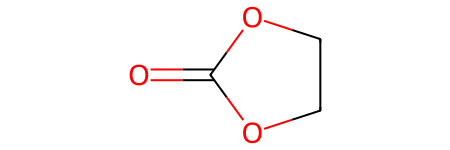

In [3]:
EC_smi = "C1COC(=O)O1"

EC = Chem.MolFromSmiles(EC_smi)

EC

### Morgan/Circular/ECFP fingerprints

In [4]:
from rdkit.Chem import AllChem

# Create generator
morgan_generator = AllChem.GetMorganGenerator(radius=2)

# Generate the Morgan fingerprint
morgan_fp = morgan_generator.GetFingerprint(EC)

# Convert the fingerprint to a binary string
fp_binary = morgan_fp.ToBitString()

print("Fingerprint length:", len(fp_binary))

print("First five bits:", fp_binary[:5])

Fingerprint length: 2048
First five bits: 00000


## Crystal composition & structure   

In [5]:
from pymatgen.core import Structure

filename = "./data/NaCl.POSCAR"

NaCl = Structure.from_file(filename)

print(NaCl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.588126   5.588126   5.588126
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na    0    0    0
  1  Na    0    0.5  0.5
  2  Na    0.5  0    0.5
  3  Na    0.5  0.5  0
  4  Cl    0    0    0.5
  5  Cl    0    0.5  0
  6  Cl    0.5  0    0
  7  Cl    0.5  0.5  0.5


In [6]:
NaCl_comp = NaCl.composition

NaCl_comp

Composition('Na4 Cl4')

### Visualize it

In [7]:
import crystal_toolkit

NaCl

If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 5.588126435439935 5.588126435439935 5.588126435439935
 angles : 90.0 90.0 90.0
 volume : 174.50130186202978
      A : 5.588126435439935 0.0 3e-16
      B : 9e-16 5.588126435439935 3e-16
      C : 0.0 0.0 5.588126435439935
    pbc : True True True
PeriodicSite: Na (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Na (4.5e-16, 2.794, 2.794) [0.0, 0.5, 0.5]
PeriodicSite: Na (2.794, 0.0, 2.794) [0.5, 0.0, 0.5]
PeriodicSite: Na (2.794, 2.794, 3e-16) [0.5, 0.5, 0.0]
PeriodicSite: Cl (0.0, 0.0, 2.794) [0.0, 0.0, 0.5]
PeriodicSite: Cl (4.5e-16, 2.794, 1.5e-16) [0.0, 0.5, 0.0]
PeriodicSite: Cl (2.794, 0.0, 1.5e-16) [0.5, 0.0, 0.0]
PeriodicSite: Cl (2.794, 2.794, 2.794) [0.5, 0.5, 0.5]

## Matminer 

### Compositional descriptor

In [8]:
from matminer.featurizers.composition import ElementProperty

ep = ElementProperty.from_preset(preset_name="magpie")
features = ep.featurize(NaCl_comp)

# Length of the feature vector
len(features)

132

In [9]:
# First 5 features
features[:5]

[11.0, 17.0, 6.0, 14.0, 3.0]

In [10]:
# What are these features?

labels = ep.feature_labels()

labels[:5]

['MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number']

### Structure descriptor 

In [11]:
from matminer.featurizers.structure import RadialDistributionFunction

cutoff = 20
rdf = RadialDistributionFunction(cutoff=cutoff)

features = rdf.featurize(NaCl)

len(features)

200

In [12]:
features.shape

(200,)

Text(0, 0.5, 'Radial distribution function')

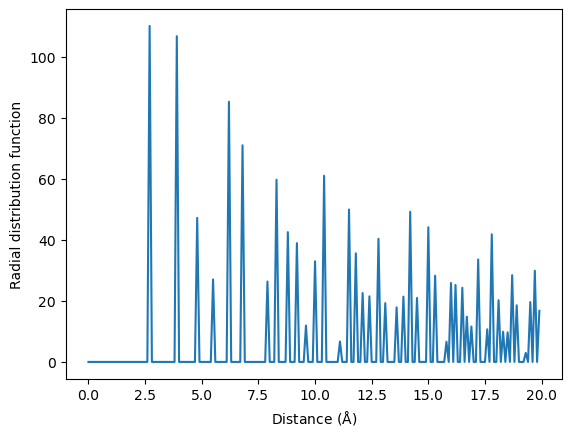

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

X = np.arange(0, cutoff, cutoff/len(features))
Y = features

ax.plot(X, Y)

ax.set_xlabel(r"Distance $(\mathrm{\AA})$")
ax.set_ylabel("Radial distribution function")

## Crystal composition & structure   
 
- ASE (an alternative to pymatgen)

In [14]:
from ase.io import read

NaCl = read("./data/NaCl.POSCAR")

NaCl

Atoms(symbols='Na4Cl4', pbc=True, cell=[[5.588126435439935, 0.0, 3e-16], [9e-16, 5.588126435439935, 3e-16], [0.0, 0.0, 5.588126435439935]])

In [15]:
from ase.visualize import view

view(NaCl, viewer='x3d')

## SOAP Descriptor

In [16]:
from dscribe.descriptors import SOAP

soap = SOAP(r_cut=5, n_max=8, l_max=6, species=["Na", "Cl"], periodic=True)

features = soap.create(NaCl)

# The shape is (n_atoms, n_features)
features.shape

(8, 952)

In [17]:
# The first 10 features for the first atom
features[0][:10]

array([ 0.01150823,  0.05439198,  0.08569168,  0.30573843,  0.00483586,
        0.906287  , -1.43857222,  2.26457369,  0.25707582,  0.40500933])